<a href="https://colab.research.google.com/github/ziadel-kent/deep-learning-project/blob/main/mask_classification_bonus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("omkargurav/face-mask-dataset")

print("Path to dataset files:", '/content/drive/MyDrive/massk.zip')


100%|██████████| 163M/163M [00:06<00:00, 28.1MB/s]

Extracting files...


Path to dataset files: /content/drive/MyDrive/massk.zip


In [ ]:

import os
import cv2
import zipfile
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow
from tensorflow import keras
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from warnings import filterwarnings

# Specify the path to your zip file
zip_file_path = '/content/drive/MyDrive/massk.zip'

# Specify the directory where you want to extract the contents
extract_dir = '/content/Face_Mask_Dataset/data'  # Choose a suitable directory

# Create the extraction directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile('/content/drive/MyDrive/massk.zip', 'r') as zip_ref:
    zip_ref.extractall(extract_dir)





In [ ]:
# Step 2: Load and Preprocess the Dataset
data = []
categories = ['with_mask', 'without_mask']

for category in categories:
    path = os.path.join('/content/Face_Mask_Dataset/data/data', category)
    label = 0 if category == 'with_mask' else 1

    for file in os.listdir(path):
        img_path = os.path.join(path, file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            data.append([img, label])

# Shuffle the data
random.Random(4).shuffle(data)

# Split features and labels
X = np.array([feature for feature, label in data])
y = np.array([label for feature, label in data])
X = X / 255.0  # Normalize the images


In [ ]:
from tensorflow.keras.utils import to_categorical
# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [ ]:
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.applications import ResNet152V2
# Step 4: Build the Model
base_model = ResNet152V2(include_top=False, weights="imagenet", input_shape=(128, 128, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    BatchNormalization(),
    Dense(1024, activation='relu'),
    Dropout(rate=0.2),
    BatchNormalization(),
    Dense(1024, activation='relu'),
    Dropout(rate=0.2),
    Dense(2, activation='softmax')  # Softmax for multi-class classification
])

model.summary()


234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet152v2 (Functional)             │ (None, 4, 4, 2048)          │      58,331,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32768)               │         131,072 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      33,555,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │           2,050 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 93,073,922 (355.05 MB)

 Trainable params: 34,674,690 (132.27 MB)

 Non-trainable params: 58,399,232 (222.78 MB)

In [ ]:
from tensorflow.keras.optimizers import Adam
# Step 5: Compile the Model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Step 6: Train the Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32,
    verbose=1
)

Epoch 1/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 85s 286ms/step - accuracy: 0.9473 - loss: 0.1324 - val_accuracy: 0.9821 - val_loss: 0.0670
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 32s 91ms/step - accuracy: 0.9947 - loss: 0.0165 - val_accuracy: 0.9868 - val_loss: 0.0674
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 19s 103ms/step - accuracy: 0.9979 - loss: 0.0078 - val_accuracy: 0.9841 - val_loss: 0.0739
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 19s 94ms/step - accuracy: 0.9987 - loss: 0.0047 - val_accuracy: 0.9821 - val_loss: 0.0857
Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 18s 94ms/step - accuracy: 0.9994 - loss: 0.0020 - val_accuracy: 0.9841 - val_loss: 0.0885
Epoch 6/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 18s 95ms/step - accuracy: 0.9990 - loss: 0.0064 - val_accuracy: 0.9841 - val_loss: 0.0876
Epoch 7/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.9988 - loss: 0.0030 - val_accuracy: 0.9821 - val_loss: 0.0985
Epoch 8/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.9998 - loss: 9.612

In [ ]:

# Step 7: Evaluate the Model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.9856 - loss: 0.1196
Test Loss: 0.11997833102941513
Test Accuracy: 0.9867637157440186


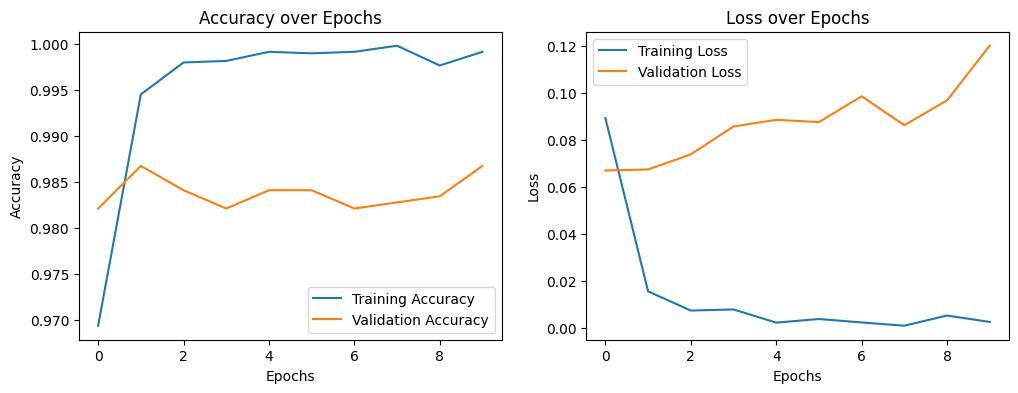

In [ ]:
# Step 8: Plot Training History
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.show()

48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step


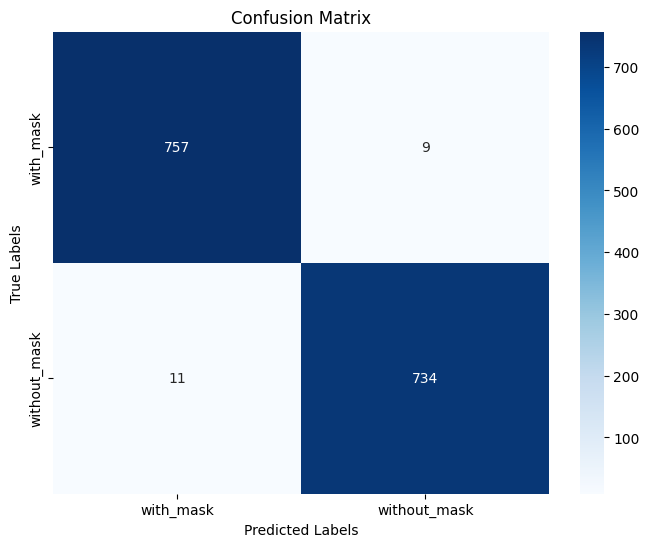

In [ ]:
# Step 9: Confusion Matrix and Classification Report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Step 9: Confusion Matrix and Classification Report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
print("Confusion Matrix:")
print(conf_matrix)

In [ ]:
model.save('/content/model.h5')

ResNet152V2 model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
Predicted class index for /content/withzz.jpeg: 0
Predicted class name for /content/withzz.jpeg: with_mask


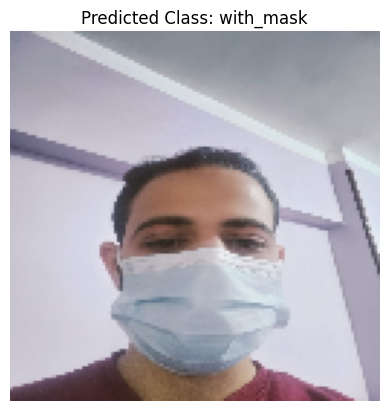

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Predicted class index for /content/outzz.jpeg: 1
Predicted class name for /content/outzz.jpeg: without_mask


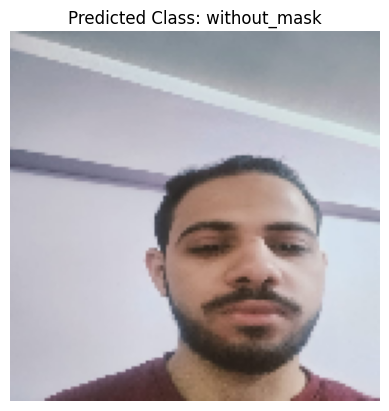

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted class index for /content/sec.jpeg: 0
Predicted class name for /content/sec.jpeg: with_mask


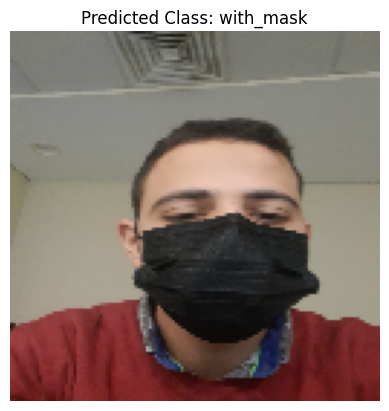

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Predicted class index for /content/menio.jpeg: 0
Predicted class name for /content/menio.jpeg: with_mask


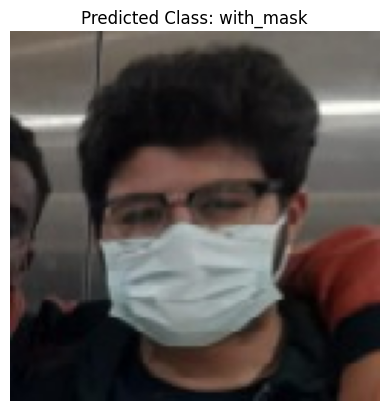

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Predicted class index for /content/ff.jpeg: 0
Predicted class name for /content/ff.jpeg: with_mask


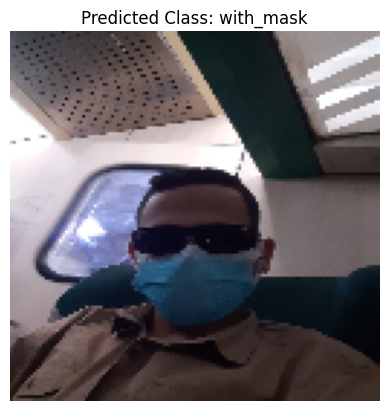

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Predicted class index for /content/tasm.jpeg: 1
Predicted class name for /content/tasm.jpeg: without_mask


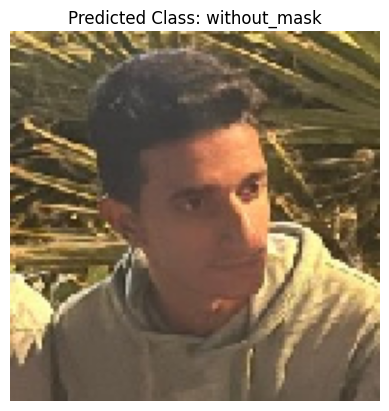

In [ ]:
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet_v2 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt

# Load the saved ResNet152V2 model
model = load_model('/content/model.h5')  # Update with your model path
print("ResNet152V2 model loaded successfully!")

# List of test image paths (update with your image paths)
test_image_paths = [
    '/content/with.jpg',
    '/content/out.jpg',
    '/content/withzz.jpeg',
    '/content/outzz.jpeg',
    '/content/sec.jpeg',
    '/content/menio.jpeg',
    '/content/ff.jpeg',
    '/content/tasm.jpeg'


]

# Define class labels (update with your actual labels)
class_labels = ['with_mask', 'without_mask']

# Function to process and predict each image
for image_path in test_image_paths:
    # Load and preprocess the image
    img = load_img(image_path, target_size=(128, 128))  # Resize to 224x224
    img_array = img_to_array(img)  # Convert to array
    img_array = preprocess_input(img_array)  # Apply ResNet152V2 preprocessing
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict the label of the test image
    predictions = model.predict(img_array)

    # Get the index of the predicted class
    predicted_class = np.argmax(predictions)
    print(f"Predicted class index for {image_path}: {predicted_class}")

    # Map the predicted index to the class name
    predicted_class_name = class_labels[predicted_class]
    print(f"Predicted class name for {image_path}: {predicted_class_name}")

    # Display the test image with the predicted label
    plt.figure()
    plt.imshow(img)
    plt.title(f"Predicted Class: {predicted_class_name}")
    plt.axis('off')
    plt.show()


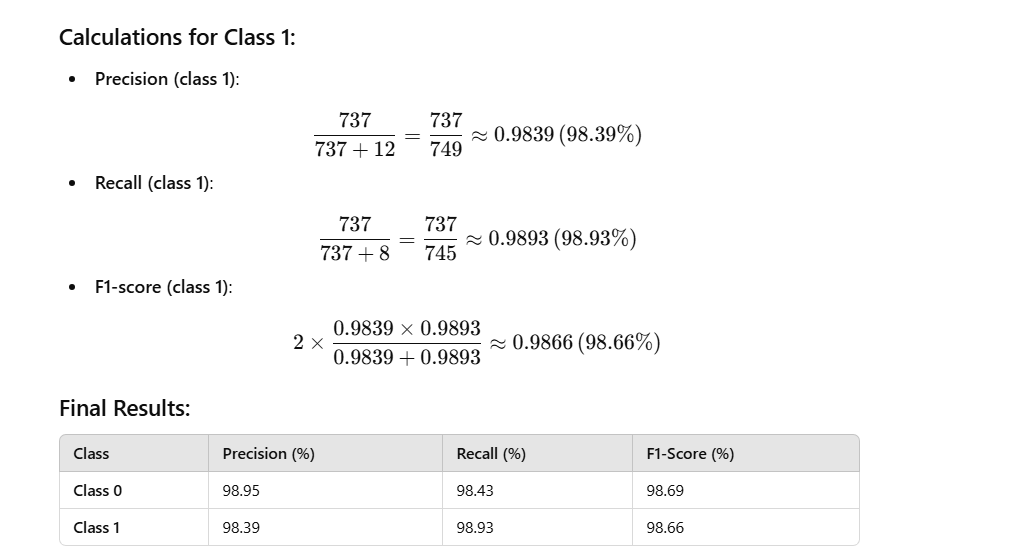

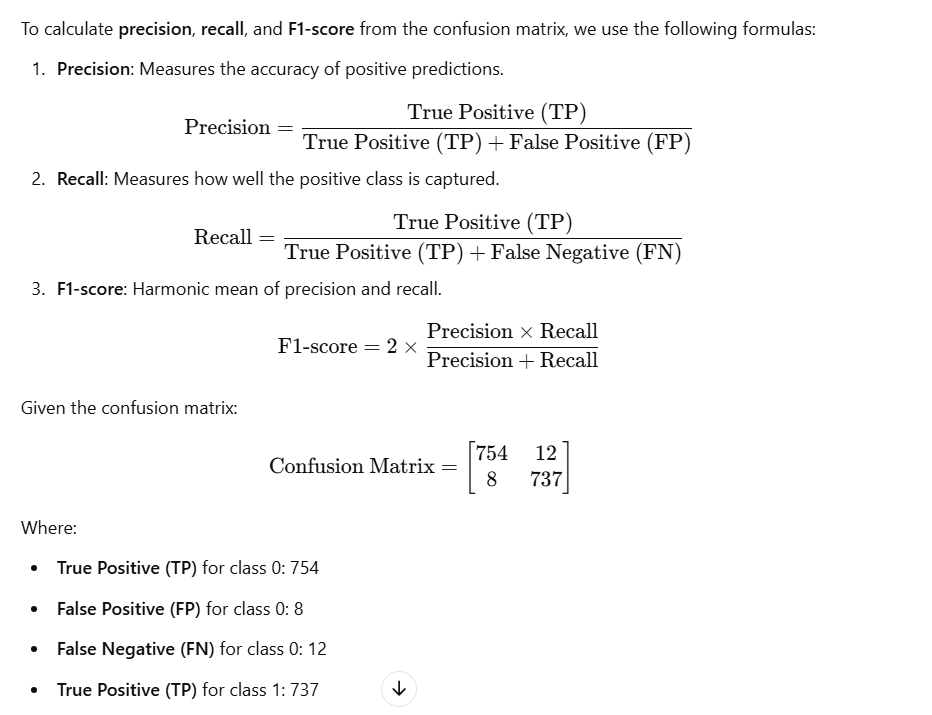